In [1]:
import sys
import os
sys.path.append("../..")
from diachr import DiachromaticInteractionSet
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Create directory for output files generated in this notebook 
NOTEBOOK_RESULTS_DIR = 'results/restriction_fragment_lengths'
%mkdir -p $NOTEBOOK_RESULTS_DIR

# Restriction fragment lengths

Longer restriction fragments may be more prone to random re-ligations than shorter restriction fragments. In this notebook, we compare the lengths of restriction fragments that are either associated only with balanced or only unbalanced interactions.

## Loading interaction data

### Choose an interaction file

In [2]:
AUTHOR = 'MIF' # JAV, SCH, MIF
PROTOCOL = 'CHC' # HC or CHC
CELL_TYPE_SHORT = 'GM12878' # MK, ERY, NEU, MON, MAC_M0, ..., MESC, MFLC, MESC_R1ABKO, GM12878
OUT_PREFIX = AUTHOR + '_' + CELL_TYPE_SHORT + '_' + PROTOCOL +'_REPC'
INTERACTION_FILE = '../../UICer_interactions/' + PROTOCOL + '/' + OUT_PREFIX + '_evaluated_and_categorized_interactions.tsv.gz' 

### Read interactions into data structure

In [3]:
# Create DiachromaticInteractionSet
d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../../UICer_interactions/CHC/MIF_GM12878_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Set size: 1,892,588
[INFO] ... done.


## Implement function to create boxplots for fragment lengths

In [4]:
def create_rfl_boxplot(
    u_list=None, # BDC0 5' bait
    b_list=None, # BDC0 3' bait
    showfliers = True,
    title='TITEL',
    xlabel='XLAB_L',
    output_pdf='OUT.pdf'):

    # Set up figure
    fig, (ax1, ax2) = plt.subplots(1,2)
    box_width = 0.5
    ax1.set_title(title, loc='left')
    
    # Determine range to be displayed    
    xmin = min(u_list + b_list)
    xmax = max(u_list + b_list)
    padding = (xmax-xmin)/30
    xmin = xmin - padding
    xmax = xmax + padding        

    # Create boxplots for 5' baits (left)
    bp1 = ax1.boxplot(
        [u_list, b_list],
        widths=(box_width, box_width),
        patch_artist=True,
        labels=['Unbalanced\nn=' + '{:,}'.format(len(u_list)),
                'Balanced\nn=' + '{:,}'.format(len(b_list))],
        vert=False,
        showfliers=showfliers
    )
    colors = ['orange', 'lightblue']
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
    ax1.set_xlabel(xlabel)
    
    # Highlight the area between the first and the third quantiles of the 5' distances of BDC0 in gray
    shaded_q1, shaded_q2, shaded_q3 = np.quantile(b_list, [0.25, 0.50, 0.75])
    ax1.axvspan(shaded_q1, shaded_q3, facecolor='gray', alpha=0.2)
    ax1.axvline(shaded_q2, color='lightgray', zorder=0)


    # Set limits of the x-axes
    #if showfliers is False:
    xmin_1, xmax_1 = ax1.get_xlim()
    xmin = min([xmin_1, xmax_1])
    xmax = max([xmin_1, xmax_1])
    ax1.set_xlim(xmin,xmax)
    padding = (xmax-xmin)/30
    xmin = xmin - padding
    xmax = xmax + padding

    # Format figure and write to PDF file
    fig.set_figheight(3)
    fig.set_figwidth(8.5)#7.5
    fig.tight_layout()
    fig.savefig(output_pdf)

## Get two fragment sets associated with either balanced or unbalanced interactions

A given fragment can be associated with both balanced and unbalanced interactions. Therefore we determine two sets of fragments associated either only with balanced or only with unbalanced interactions.

In [5]:
u_frags = set()
b_frags = set()
for d_inter in d11_interaction_set.interaction_list:
    frag_5 = d_inter.chrA + ':' + str(d_inter.fromA) + '-' + str(d_inter.toA)
    frag_3 = d_inter.chrB + ':' + str(d_inter.fromB) + '-' + str(d_inter.toB)
    if d_inter.get_category() == 'BR' or d_inter.get_category() == 'BX':
        b_frags.add(frag_5)
        b_frags.add(frag_3)
    if d_inter.get_category() == 'UR' or d_inter.get_category() == 'UX':
        u_frags.add(frag_5)
        u_frags.add(frag_3)
u_only_frags = u_frags.difference(b_frags)
b_only_frags = b_frags.difference(u_frags)

## Get lists of fragment lengths

In [6]:
u_only_frag_len = list()
b_only_frag_len = list()
for frag in u_only_frags:
    chrom, coords = frag.split(':')
    sta, end = coords.split('-')
    f_len = int(end) - int(sta)
    u_only_frag_len.append(f_len)
for frag in b_only_frags:
    chrom, coords = frag.split(':')
    sta, end = coords.split('-')
    f_len = int(end) - int(sta)
    b_only_frag_len.append(f_len)

## Report summary statistics and test

In [7]:
print("Fragments involved only in balanced interactions: " + '{:,}'.format(len(b_only_frags)))
print("Fragments involved only in unbalanced interactions: " + '{:,}'.format(len(u_only_frags)))
print("Median length of fragments involved only in balanced interactions: " + '{:,}'.format(int(np.median(b_only_frag_len))))
print("Median length of fragments involved only in unbalanced interactions: " + '{:,}'.format(int(np.median(u_only_frag_len))))
print("Test whether fragment lengths differ significantly: Balanced vs. unbalanced")
print('\t' + str(stats.mannwhitneyu(b_only_frag_len, u_only_frag_len, alternative='two-sided')))

Fragments involved only in balanced interactions: 198,310
Fragments involved only in unbalanced interactions: 65,007
Median length of fragments involved only in balanced interactions: 2,304
Median length of fragments involved only in unbalanced interactions: 2,872
Test whether fragment lengths differ significantly: Balanced vs. unbalanced
	MannwhitneyuResult(statistic=5743636241.5, pvalue=0.0)


## Create boxplot

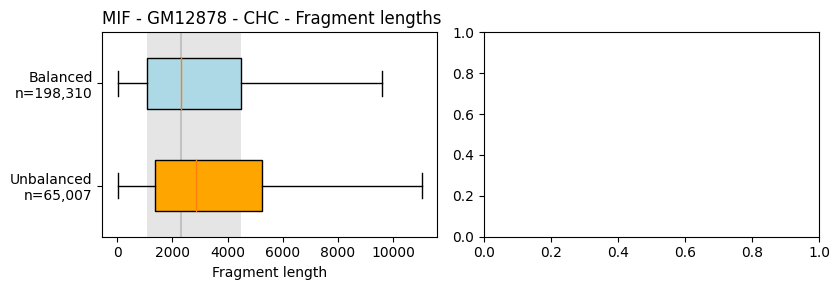

In [8]:
create_rfl_boxplot(
    u_list=u_only_frag_len,
    b_list=b_only_frag_len,
    showfliers=False,
    title= AUTHOR + ' - ' + CELL_TYPE_SHORT + ' - ' + PROTOCOL + ' - Fragment lengths',
    xlabel='Fragment length',
    output_pdf=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_restriction_fragment_lengths.pdf')